## Модуль А. Парсинг и предобработка данных

#### Импортирование библиотек

In [1]:
import pandas as pd
import numpy as np
import json
import requests
import codecs
import glob
from bs4 import BeautifulSoup as bs
from docx import Document
from tqdm.auto import tqdm, trange
import nltk
import matplotlib.pyplot as plt
import pymorphy2
import string

import re
from nltk.stem import *
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from scipy.stats import anderson
from scipy.stats import normaltest
import pylab 
import scipy.stats as stats

### 1.1 Парсинг данных

#### Парсинг данных с json

In [2]:
path = r"C:\Users\МОиБД\Desktop\Data\*.json"
result_list = {'name': [],'desc': [],'rat':[], 'date': [], 'textart': []}
company_json = []
# Использование glob для получения списка файлов, соответствующих шаблону
json_files = glob.glob(path)
# Цикл по файлам JSON для извлечения данных
for jsonfile in json_files:
    # Чтение файла JSON и преобразование данных в словарь Python
    with codecs.open(jsonfile, 'r', encoding = 'utf-8') as f:
        data = json.load(f)
        for item in data['refs']:
            if item != None:
                try:
                    if data['info']!= None:
                        result_list['desc'].append(data['info']['about'])
                        result_list['rat'].append(data['info']['rate'])
                    else:
                        result_list['desc'].append(data['info'])
                        result_list['rat'].append(data['info'])
                    result_list['name'].append(jsonfile.replace('C:\\Users\\МОиБД\\Desktop\\Data\\', '')[:-5])    
                    result_list['date'].append(item[1]['day'] + " " + item[1]['month'])
                    result_list['textart'].append(item[0])
                except:
                    break
        

In [3]:
# создание датафрейма для записи в него из json
dfJson = pd.DataFrame({
'TitleCompany': [],
'Description': [],
'Reiting': [],
'DatePublish': [],
'TextPost': []
})

In [4]:
# запись данных в датафрейм ид Json
dfJson['TitleCompany'] = result_list['name']
dfJson['Description'] = result_list['desc']
dfJson['Reiting'] = result_list['rat']
dfJson['DatePublish'] = result_list['date']
dfJson['TextPost'] = result_list['textart']

In [5]:
dfJson.head(10)

,TitleCompany,Description,Reiting,DatePublish,TextPost
0,Cybersport.Metaratings,None,NaN,8 декабря,7 декабря состоялась церемония награждения лау...
1,ESforce Holding,None,NaN,8 декабря,7 декабря состоялась церемония награждения лау...
2,ESforce Holding,None,NaN,29 июля,Из совместного исследования издателя компьютер...
3,ESforce Holding,None,NaN,9 июля,По статистике The Esports Observer за I полови...
4,ESforce Holding,None,NaN,11 апреля,Компании SuperData Research и PayPal провели с...
5,Gett,None,NaN,29 марта,Минтранс предлагает новую версию законопроекта...
6,Gett,None,NaN,11 марта,"По информации «РИА Новости», агрегатор такси «..."
7,Gett,None,NaN,22 февраля,"Как сообщает издание Wired, с 1 марта 2022 год..."
8,Gett,None,NaN,21 февраля,Китайский агрегатор такси DiDi уйдет с российс...
9,Gett,None,NaN,7 февраля,"По информации издания «Известия», антимонополь..."


In [6]:
dfJson.shape

(1112, 5)

In [7]:
dfJson.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TitleCompany  1112 non-null   object 
 1   Description   293 non-null    object 
 2   Reiting       293 non-null    float64
 3   DatePublish   1112 non-null   object 
 4   TextPost      1112 non-null   object 
dtypes: float64(1), object(4)
memory usage: 43.6+ KB


In [8]:
dfJson['TitleCompany'].unique()

array(['Cybersport.Metaratings', 'ESforce Holding', 'Gett',
       'Goose Gaming', 'skillbox', 'Vinci Agency', 'Гэллэри Сервис',
       'Здоровье.ру', 'Иннотех',
       'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта для анализа медицинских изображений',
       'Промобот', 'Студия Артемия Лебедева',
       'Федерация креативных индустрий'], dtype=object)

#### Парсинг данных с docx 

In [9]:
# Получение doc документа в переменную
path = r"C:\Users\МОиБД\Desktop\Data\Condidates.docx" 
doc = Document(path)

In [10]:
# сохранение данных
docx = doc.paragraphs

In [11]:
# считывание компаний и запись их в список
company_docx = []
for docs in docx:
    if len(docs.text) != 0:
        if docs.text[-1] != " ":
            company_docx.append(docs.text)
        else:
            company_docx.append(docs.text.replace(' ', ''))

In [12]:
for i in range(len(company_docx)):
    print(i, company_docx[i])

0 Здоровье.ру
1 Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта (ИИ) для анализа медицинских изображений
2 Skillbox
3 Gett
4 Промобот
5 Иннотех
6 Cybersport.Metaratings
7 MMA.Metaratings
8 Goose Gaming
9 ESforce Holding
10 Vinci Agency
11 Гэллэри Сервис
12 Студия Артемия Лебедева
13 Федерация креативных индустрий
14 Метарейтинг
15 СберМаркет
16 Balance Platform
17 Московская биржа
18 Samsung Electronics
19 Нетология
20 Дневник МЭШ
21 Цифровое образование


#### Ненужный, в данном случае, код
//

In [14]:
#df = pd.DataFrame({"TitleCompany": []})

In [15]:
#df['TitleCompany'] = company_docx

In [16]:
#dfNeedCompany = {"TitleCompany": []}

In [17]:
# for i in df['TitleCompany']:
#     if i.lower() in str(dfJson['TitleCompany'].unique()).lower():
#         continue
#     else:
#         dfNeedCompany['TitleCompany'].append(i)
# dfNeedCompany = pd.DataFrame(data = dfNeedCompany)
# dfNeedCompany = dfNeedCompany.drop(0, axis=0)
# dfNeedCompany = dfNeedCompany.drop(9, axis=0)
# dfNeedCompany = dfNeedCompany.reset_index(drop=True)

При парсинге цифрового образования выводятся две компании, которые не подходят к списку компаний, поэтому цифоровое образование удалено из датафрейма, такой компании на хабре все равно не существует. А также удалена компания 'Проект по использованию технологий компьютерного зрения...', т.к. компания одна и даже в ворде и json, но в одном из файлов есть лишний символ, из-за чего удален он вручную.

In [18]:
#dfNeedCompany

//

#### Парсинг данных с Habr компаний, для автоматического добавления

In [13]:
dfNeedCompany = {"TitleCompany": []}
dfNeedCompany['TitleCompany'] = company_docx

In [14]:
dfNeedCompany

{'TitleCompany': ['Здоровье.ру',
  'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта (ИИ) для анализа медицинских изображений',
  'Skillbox',
  'Gett',
  'Промобот',
  'Иннотех',
  'Cybersport.Metaratings',
  'MMA.Metaratings',
  'Goose Gaming',
  'ESforce Holding',
  'Vinci Agency',
  'Гэллэри Сервис',
  'Студия Артемия Лебедева',
  'Федерация креативных индустрий',
  'Метарейтинг',
  'СберМаркет',
  'Balance Platform',
  'Московская биржа',
  'Samsung Electronics',
  'Нетология',
  'Дневник МЭШ',
  'Цифровое образование']}

In [15]:
dfHabr = {"TitleCompany": [], 'Description': [], 'Reiting' : [], 'Categories' : [], 'DatePublish': [], "TextPost": []}

In [16]:
# перебираем необходимые компании
for j in tqdm(range(1, 50)):
    for i in dfNeedCompany['TitleCompany']:
        if " " in i:
            i = i.replace(" ", "%20")
        # запись компании в поиск
        url = 'https://habr.com/ru/search/?q='+ i +'&target_type=companies&order=relevance'
        page = requests.get(url)
        soup = bs(page.text, 'html.parser')
        # переход к компании
        pages = soup.find_all('div', class_='tm-company-snippet__info')
        for i in pages:
            url = 'https://habr.com' + str(i.a.get('href'))
            page = requests.get(url)
            soup = bs(page.text, 'html.parser')
            # запись названия, описания, рейтинга, категорий компании
            TitleCompanyForName = soup.find('a', class_='tm-company-card__name router-link-exact-active router-link-active') 
            description = soup.find('div', class_='tm-company-card__description')
            reiting = soup.find('span', class_='tm-votes-lever__score-counter tm-votes-lever__score-counter tm-votes-lever__score-counter_rating')
            Categories = soup.find('div', class_='tm-company-profile__categories')
            # переход на блог компании
            pages = soup.find_all('a', class_='tm-tabs__tab-link tm-tabs__tab-link')
            for i in pages:  
                url = 'https://habr.com' + str(i.get('href')) + 'page' + str(j) + '/'
                if 'articles' in str(i.get('href')):
                    print(url)
                    page = requests.get(url)
                    if page.status_code == 200:
                        soup = bs(page.text, 'html.parser')
                        # переход по постам компаний
                        pages = soup.find_all('h2', class_='tm-title tm-title_h2')
                        for i in pages:
                            url = 'https://habr.com' + str(i.a.get('href'))
                            page = requests.get(url)
                            soup = bs(page.text, 'html.parser')
                            TextPost = soup.find('div', class_='tm-article-body')
                            DatePublish = soup.find('span', class_='tm-article-datetime-published')
                            # запись всех необходимых данных
                            dfHabr["TextPost"].append(TextPost.text)
                            dfHabr['TitleCompany'].append(TitleCompanyForName.text)
                            dfHabr['Description'].append(description.text)
                            dfHabr['Reiting'].append(reiting.text)
                            dfHabr['Categories'].append(Categories.text)
                            dfHabr['DatePublish'].append(DatePublish.text)
                    else:
                        print(url, 'Страницы не существует')

  0%|          | 0/49 [00:00<?, ?it/s]

https://habr.com/ru/companies/skillbox/articles/page1/


KeyboardInterrupt: 

К сожалению, в парсинге выше обработались только 8 компаний, т.к. на хабре есть только они, других компаний нет.

In [ ]:
dfHabr1 = pd.DataFrame(dfHabr)

## Импорт
готового датасета, чтобы не запускать заново лемматизацию и парсинг хабра

In [17]:
dfHabr1 = pd.read_csv(r'C:\Users\МОиБД\Downloads\Report1 (1).csv')

In [18]:
TextPostLemat1 = dfHabr1['TextPostLemat']

In [19]:
dfHabr1 = dfHabr1.drop(['TextPostToken', 'bigram', 'trigram', 'keyword', 'Nominations', 'TextPostLemat'], axis=1)

In [20]:
dfHabr1 = dfHabr1[1112:].reset_index(drop=True)

## Импорт 

In [21]:
dfHabr1.sample(5)

,TitleCompany,Reiting,DatePublish,TextPost,Categories
798,Samsung Electronics,70.64,15 ноя 2011 в 19:09,\n\r\nРедкое устройство сегодня способно удив...,связь и телекоммуникации мобильные технологии
229,Samsung Electronics,70.64,3 окт 2019 в 20:43,Сегодня мы хотим ответить на вопрос «Нужно ли...,связь и телекоммуникации мобильные технологии
537,Skillbox,120.11,6 ноя 2018 в 15:34,\n\r\nОт переводчика: этот пост — перевод ори...,веб разработка дизайн и юзабилити реклама и м...
738,Samsung Electronics,70.64,2 сен 2012 в 12:56,"Так уж получилось, что вокруг меня просто куч...",связь и телекоммуникации мобильные технологии
8,Skillbox,120.11,20 сен 2022 в 13:15,"Хабр, привет! Меня зовут Даниил Пилипенко, я ...",веб разработка дизайн и юзабилити реклама и м...


In [22]:
dfHabr1.shape

(905, 5)

In [23]:
dfHabr1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TitleCompany  905 non-null    object
 1   Reiting       905 non-null    object
 2   DatePublish   905 non-null    object
 3   TextPost      905 non-null    object
 4   Categories    905 non-null    object
dtypes: object(5)
memory usage: 35.5+ KB


In [24]:
for i in range(len(company_docx)):
    print(i, company_docx[i])

0 Здоровье.ру
1 Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта (ИИ) для анализа медицинских изображений
2 Skillbox
3 Gett
4 Промобот
5 Иннотех
6 Cybersport.Metaratings
7 MMA.Metaratings
8 Goose Gaming
9 ESforce Holding
10 Vinci Agency
11 Гэллэри Сервис
12 Студия Артемия Лебедева
13 Федерация креативных индустрий
14 Метарейтинг
15 СберМаркет
16 Balance Platform
17 Московская биржа
18 Samsung Electronics
19 Нетология
20 Дневник МЭШ
21 Цифровое образование


In [25]:
dfHabr1['TitleCompany'].unique()

array(['Skillbox', 'Иннотех', 'СберМаркет', 'MOEX', 'Samsung Electronics',
       'Нетология', 'Учи.ру team',
       'Команда Цифровой Трансформации Татарстана'], dtype=object)

In [26]:
dfJson['TitleCompany'].unique()

array(['Cybersport.Metaratings', 'ESforce Holding', 'Gett',
       'Goose Gaming', 'skillbox', 'Vinci Agency', 'Гэллэри Сервис',
       'Здоровье.ру', 'Иннотех',
       'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта для анализа медицинских изображений',
       'Промобот', 'Студия Артемия Лебедева',
       'Федерация креативных индустрий'], dtype=object)

__Итог 1.1 Парсинг данных__

Были отпарсины файл docx для списка номинантов, в котором вышло 22 компании.

Затем был отпарсин json, в котором было 1112 записей, компаниями были: 'Cybersport.Metaratings', 'ESforce Holding', 'Gett','Goose Gaming', 'Skillbox', 'Vinci Agency', 'Гэллэри Сервис', Здоровье.ру', 'Иннотех', 'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта для анализа медицинских изображений','Промобот', 'Студия Артемия Лебедева', 'Федерация креативных индустрий' компаний получилось 13. 

А также с хабра по поиску отпарсины компании, каждые из существующих по 50 страниц. Но ни у одной компании из присутствующих не было 30-ти страниц. Отпарсить получилось только эти компании: 'Skillbox', 'Иннотех', 'СберМаркет', 'MOEX', 'Samsung',
'Нетология', 'Учи.ру team','Команда Цифровой Трансформации Татарстана' две последние компании появляются при поиске компании 'Цифровое образование'.

Компании 

Gett, MMA.Metaratings, Метарейтинг, Balance Platform, Дневник МЭШ не существуют ни в json, ни на хабре. Отсуствуют они по причине того, что их удалили с хабра по разным причинам.

### 1.2 Формирование структуры набора данных

1 __TitleCompany__ - Название компании.

2 __Description__ - Описание компании.

3 __Reiting__ - Рейтинг компании.

4 __Categories__ - Категории компании.

5 __DatePublish__ - Дата опубликования статьи.

6 __TextPost__ - необработанный текст.

7 __TextPostLemat__ - обработанный, лематизированный текст.

8 __TextPostToken__ - обработанный, токенизированный и лематизированный текст.

9 __bigram__ - биграммы обработанного и лематизированного текста.

10 __trigram__ - триграммы обработанного и лематизированного текста.

11 __keyword__ - ключевые слова обработанного и лематизированного текста.

__Пояснение исключения или выбора признаков:__

1 - __Название компании__ необходимо оставить, т.к. с ним будет производится разведочный анализ данных, а также будет производится обучение.

2 - __Описание компании__ ненужно, т.к. с ним не будут производится какие-либо работы. Поэтому оно будет просто занимать лишнее место.

3 - __Рейтинг компании__ необходим, т.к. с ним будет производится разведочный анализ.

4 - __Категории компании__ необходимы, т.к. благодаря ним можно определять принадлежность компании к определенной сфере.

5 - __Дата опубликования статьи__ необходима, т.к. с ней будет производится разведочный анализ.

6 - __Необработанный текст__ необходим для обработки текста и создания столбцов TextPostLemat и TextPostToken, а также для дальнейшего сравнения.

7 - __Обработанный, лематизированный текст__, необходим в дальнейшем для работы с разведочным анализом, а также обучения.

8 - __Обработанный, токенизированный и лематизированный текст__, необходим в дальнейшем для работы с разведочным анализом, а создания биграмм, триграмм и ключевых слов.

9 - __Биграммы__ обработанного и лематизированного текста, необходимы по заданию, а также для визуального анализа.

10 - __Триграммы__ обработанного и лематизированного текста, необходим по заданию, а также для визуального анализа.

11 - __Ключевые__ слова обработанного и лематизированного текста, необходим по заданию, а также для визуального анализа.

Следовательно исключается только 2 пункт (Описание).

In [ ]:
dfHabr1 = dfHabr1.drop(['Description'], axis=1)

In [27]:
dfJson = dfJson.drop(['Description'], axis=1)

### 1.3 Предварительная обработка текстовых данных

#### План работы

1. Обработка начинается с удаление дубликатов из датафрейма через drop_duplicates.
2. Затем создание методов для обработки данных:

Для начала создаются russian_stopwords через stopwords.words("russian"), через которые пропускаются все методы, для удаления стоп-слов.

    2.1 Метод удаление пунктуации, работает через string.punctuation, начинается обработка с него, чтобы убрать всю пунктуацию, и затем, если появятся лишние пробелы или символы дальнейшая обработка все удалила.
    
    2.2 Метод удаления чисел, работает через isdigit, аналогично удалению пунктуации идет он. 
    
    2.3 Метод удаления оставшихся чисел, работает через isalpha.
    
    2.4 Метод удаления слов меньше 3 символов, он нужен для удаление невошедших в стопслова которких слов, которые точно не нужны в уже обработанном тексте.
    
    2.5 Затем идет удаление лишних пробелов, через функцию re, необходим, чтобы после обработки данных текст был читаемым, и не было этих лишних пробелов.
    
    2.6 Затем идет лемматизация, она уже без метода, просто запускается через mystem и обрабатывает все текста, лемматизация записывается в новый столбец.
    
    2.7 Затем идет токенизация на оснвое лемматизированого текста, работает через word_tokenize
   
Каждый из этих методов необходим по заданию, а последовательность задавалась методом проб, чтобы не было лишней информации и текст был обработан корректно.
    

#### Удаление дубликатов в парсинге с хабра

In [28]:
dfHabr1.drop_duplicates(subset='TextPost', inplace=True)

In [29]:
dfHabr1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905 entries, 0 to 904
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TitleCompany  905 non-null    object
 1   Reiting       905 non-null    object
 2   DatePublish   905 non-null    object
 3   TextPost      905 non-null    object
 4   Categories    905 non-null    object
dtypes: object(5)
memory usage: 42.4+ KB


Дубликатов не было, поэтому так и осталось 905 записей

In [85]:
dfHabr1.describe()

,TitleCompany,Reiting,DatePublish,TextPost,Categories
count,905,905,905,905,905
unique,8,8,905,905,7
top,Samsung Electronics,70.64,18 апр в 15:42,Микросервисы становятся все более популярным ...,веб разработка дизайн и юзабилити реклама и м...
freq,328,328,1,1,406


#### Создание методов для полной обработки данных

In [30]:
morph = pymorphy2.MorphAnalyzer()

In [31]:
# метод удаления пунктуации
def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

# метод удаления чисел
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])

# метод удаления двойных пробелов
def remove_multiple_spaces(text):
	return re.sub(r'\s+', ' ', text, flags=re.I)

# метод удаления оставшихся чисел
def remove_notalpha(text):
    return ''.join([i if i.isalpha() else ' ' for i in text])

# метод токенизирования
def tokenize(text):
    t = word_tokenize(text)
    return [token for token in t if token not in russian_stopwords]

# метод удаления слов < 3
def remove_small_text(text):
    words = text.split()
    return ' '.join([i if len(i) >=3 else ' ' for i in words])

# объект mystem для лематизации 
mystem = Mystem() 
# добавление стопслов
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...', 'быть', 'r', 'n', 'а', 'мы', 'с', 'для', 'ещё', 'его', 'также', 'к', 'тем', 'кто', 'чтобы', 'но', 'они', 'будут', 'так', 'где', 'один', 'он ', 'и', 'на', 'но', 'или', 'либо', 'это', 'мб', 'далее', 'дв', 'свой', 'ваш','всё', 'очень', 'её', 'ещё', 'вообще', 'наш', 'который'])

#### Начало поочередной обработки данных

Ниже представлена обработка рейтинга, в ней перебирается весь столбец рейтинга в датафрейме. Сначала проверяется есть ли у текста стоп-слова, если есть, то стоп-слова удаляются, а если нет, то у текста удаляются лишние пробелы.

In [32]:
# обработка рейтинга
prep_text_Reiting = [remove_multiple_spaces(text) for text in tqdm(dfHabr1['Reiting']) if text not in russian_stopwords]

  0%|          | 0/905 [00:00<?, ?it/s]

Ниже представлена обработка категорий, в ней перебирается весь столбец категорий в датафрейме. Сначала проверяется есть ли у текста стоп-слова, если есть, то стоп-слова удаляются, а если нет, то у текста нижнего регистра удаляется пунктация, а затем лишние пробелы.

In [33]:
# обработка категорий
prep_text_Categories = [remove_multiple_spaces(remove_punctuation(text.lower())) for text in tqdm(dfHabr1['Categories']) if text not in russian_stopwords]

  0%|          | 0/905 [00:00<?, ?it/s]

In [34]:
# перезапись на обработанный текст
dfHabr1['Reiting'] = prep_text_Reiting
dfHabr1['Categories'] = prep_text_Categories

In [35]:
# обдъединение двух датафреймов с записми из json и записями с хабра
dfReady = pd.concat([dfJson, dfHabr1], ignore_index=True)

In [36]:
dfReady.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TitleCompany  2017 non-null   object
 1   Reiting       1198 non-null   object
 2   DatePublish   2017 non-null   object
 3   TextPost      2017 non-null   object
 4   Categories    905 non-null    object
dtypes: object(5)
memory usage: 78.9+ KB


#### Обработка пропусков в DataFrame

In [37]:
dfReady['Reiting'] = dfReady['Reiting'].fillna('Пусто')

In [38]:
dfReady['Categories'] = dfReady['Categories'].fillna('Пусто')

In [39]:
dfReady.sample(5)

,TitleCompany,Reiting,DatePublish,TextPost,Categories
1341,Samsung Electronics,70.64,3 окт 2019 в 20:43,Сегодня мы хотим ответить на вопрос «Нужно ли...,связь и телекоммуникации мобильные технологии
1337,Samsung Electronics,70.64,9 дек 2019 в 16:01,"Если у вас телефон Samsung, то вы, возможно, ...",связь и телекоммуникации мобильные технологии
1919,Samsung Electronics,70.64,20 сен 2011 в 16:18,Технология Samsung Smart TV объединяет телеви...,связь и телекоммуникации мобильные технологии
1952,Samsung Electronics,70.64,16 дек 2010 в 15:51,Для нас энергоэффективность — это не только в...,связь и телекоммуникации мобильные технологии
1681,Samsung Electronics,70.64,9 сен 2013 в 12:03,"Снова здравствуйте, хабражители!\n\r\nВ преды...",связь и телекоммуникации мобильные технологии


In [40]:
dfReady.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TitleCompany  2017 non-null   object
 1   Reiting       2017 non-null   object
 2   DatePublish   2017 non-null   object
 3   TextPost      2017 non-null   object
 4   Categories    2017 non-null   object
dtypes: object(5)
memory usage: 78.9+ KB


In [41]:
dfReady['TitleCompany'].unique()

array(['Cybersport.Metaratings', 'ESforce Holding', 'Gett',
       'Goose Gaming', 'skillbox', 'Vinci Agency', 'Гэллэри Сервис',
       'Здоровье.ру', 'Иннотех',
       'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта для анализа медицинских изображений',
       'Промобот', 'Студия Артемия Лебедева',
       'Федерация креативных индустрий', 'Skillbox', 'СберМаркет', 'MOEX',
       'Samsung Electronics', 'Нетология', 'Учи.ру team',
       'Команда Цифровой Трансформации Татарстана'], dtype=object)

Ниже представлена обработка публикаций, в ней перебирается весь столбец публикаций в датафрейме. Сначала проверяется есть ли у текста стоп-слова, если есть, то стоп-слова удаляются, а если нет, то у текста нижнего регистра удаляется пунктация, затем числа, потом оставшиеся числа, затем текст меньше 3 символов и лишние пробелы.

In [42]:
# обработка текста без токенизации и лематизации для отдельной колонки с лематизацией
prep_text1 = [remove_multiple_spaces(remove_small_text(remove_notalpha(remove_numbers(remove_punctuation(text.lower()))))) for text in tqdm(dfReady['TextPost']) if text not in russian_stopwords]

  0%|          | 0/2017 [00:00<?, ?it/s]

In [ ]:
dfReady['TextPostLemat'] = prep_text1

#### Лемматизация текста статей и токенизирование

Ниже представлена лемматизация, которая работает через библиотеку mystem.

In [ ]:
# обработка 1000 записей лемматизации занимает 15-16 минут по примерной оценке tqdm, библиотеке, оценивающей обработку 
lemm_texts_list = []
for text in tqdm(dfReady['TextPostLemat']):
    try:
        text_lem = mystem.lemmatize(text)
        tokens = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
        text = " ".join(tokens)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)
        
    
dfReady['TextPostLemat'] = lemm_texts_list

In [ ]:
dfReady.sample(5)

In [43]:
# из готово импорта, чтобы не лемматизировать заново
dfReady['TextPostLemat'] = TextPostLemat1

Ниже представлена токенизация, в ней перебирается весь столбец лемматизированного текста в датафрейме. Сначала проверяется есть ли у текста стоп-слова, если есть, то стоп-слова удаляются, а если нет, то у текста нижнего регистра производится токенизация.

In [44]:
prep_text_token = [tokenize((text.lower())) for text in tqdm(dfReady['TextPostLemat']) if text not in russian_stopwords]

  0%|          | 0/2017 [00:00<?, ?it/s]

In [45]:
dfReady['TextPostToken'] = prep_text_token

In [46]:
dfReady.sample(5)

,TitleCompany,Reiting,DatePublish,TextPost,Categories,TextPostLemat,TextPostToken
340,skillbox,113.82,17 января,Драйвер и навигатор в действии (северокорейски...,Пусто,драйвер навигатор действие северокорейский вар...,"[драйвер, навигатор, действие, северокорейский..."
1637,Нетология,89.34,1 апр 2020 в 10:29,Продуктовый аналитик — мостик между бизнесом ...,веб разработка дизайн и юзабилити реклама и м...,продуктовый аналитик мостик бизнес данные рабо...,"[продуктовый, аналитик, мостик, бизнес, данные..."
962,Студия Артемия Лебедева,Пусто,26 марта,"Привет, Хабр! Сегодня мы опубликовали результа...",Пусто,привет хабр сегодня опубликовывать результат е...,"[привет, хабр, сегодня, опубликовывать, резуль..."
1527,Skillbox,120.11,15 мар 2019 в 17:29,\n\r\nКогда я занимался изучением производите...,веб разработка дизайн и юзабилити реклама и м...,заниматься изучение производительность алгорит...,"[заниматься, изучение, производительность, алг..."
1216,Нетология,89.34,10 мар в 18:18,"Фрод (от английского — fraud, «обман») в сфер...",веб разработка дизайн и юзабилити реклама и м...,фрод английский fraud обман сфера приложение в...,"[фрод, английский, fraud, обман, сфера, прилож..."


In [47]:
dfReady.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TitleCompany   2017 non-null   object
 1   Reiting        2017 non-null   object
 2   DatePublish    2017 non-null   object
 3   TextPost       2017 non-null   object
 4   Categories     2017 non-null   object
 5   TextPostLemat  2017 non-null   object
 6   TextPostToken  2017 non-null   object
dtypes: object(7)
memory usage: 110.4+ KB


In [86]:
dfReady.describe()

C:\ProgramData\anaconda3\lib\site-packages\pandas\core\algorithms.py:990: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  keys, counts = value_counts_arraylike(values, dropna)


,TitleCompany,Reiting,DatePublish,TextPost,Categories,TextPostLemat,TextPostToken,bigram,trigram,keyword,count_matrix
count,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
unique,19,11,1244,1993,8,1820,1820,1820,1820,1819,2017
top,Skillbox,Пусто,8 декабря,7 декабря состоялась церемония награждения лау...,Пусто,декабрь состояться церемония награждение лауре...,"[декабрь, состояться, церемония, награждение, ...","[(декабрь, состояться), (состояться, церемония...","[(декабрь, состояться, церемония), (состояться...","номинация, проект, москва, премия, рунет, разв...","(0, 224)\t1\n (0, 838)\t1\n (0, 966)\t1\n ..."
freq,470,819,16,13,1112,13,13,13,13,13,1


### 1.4 Поиск ключевых слов/n-грамм. Векторизация текстов

In [48]:
dfReady['bigram'] = ''
dfReady['trigram'] = ''
dfReady['keyword'] = ''

##### Биграммы и триграммы

Биграммы и триграммы созданы через nltk.ngrams - это функция в Natural Language Toolkit (NLTK), которая генерирует n-граммы из последовательности элементов. N-граммы - это последовательности из n элементов из заданного текстового образца. Функция nltk.ngrams() возвращает итератор, который можно использовать для генерации n-грамм любого размера.

Для биграмм и триграмм я выбрал nltk.ngrams т.к. основное преимущество n-грамм заключается в том, что они могут использоваться для создания языковых моделей, которые могут предсказывать вероятность того, что заданная последовательность слов встретится в тексте. А также сама модель очень удобная и простая в использовании. 

##### Ключевые слова

Ключевые слова через nltk.FreqDist - это функция в Natural Language Toolkit (NLTK), которая используется для подсчета частоты встречаемости слов в тексте. Она принимает список слов в качестве аргумента и возвращает объект FreqDist, который содержит частоту каждого слова в списке.

Для ключевых слов я выбрал nltk.FreqDist т.к. основное преимущество использования nltk.FreqDist() заключается в том, что она может использоваться для анализа текстов и выявления наиболее часто встречающихся слов, несколько удобнее чем аналоги поиска ключевых слов.

#### Создание биграммы, триграммы и ключевых слов, а также добавления их в датафрейм

In [49]:
# использование цикла с записью биграмм в датафрейм
for i in tqdm(range(len(dfReady['TextPostToken']))):
    dfReady['bigram'][i] = list(nltk.ngrams(dfReady['TextPostToken'][i], 2))
# использование цикла с записью триграмм в датафрейм
for i in tqdm(range(len(dfReady['TextPostToken']))):
    dfReady['trigram'][i] = list(nltk.ngrams(dfReady['TextPostToken'][i], 3))
# использование цикла с записью ключевых слов в датафрейм
for i in tqdm(range(len(dfReady['TextPostToken']))):
    freq_dist = nltk.FreqDist(dfReady['TextPostToken'][i])
    top_words = [word for word, count in freq_dist.most_common(10)]
    dfReady['keyword'][i] = ', '.join(top_words)

  0%|          | 0/2017 [00:00<?, ?it/s]

  0%|          | 0/2017 [00:00<?, ?it/s]

  0%|          | 0/2017 [00:00<?, ?it/s]

In [50]:
dfReady.head()

,TitleCompany,Reiting,DatePublish,TextPost,Categories,TextPostLemat,TextPostToken,bigram,trigram,keyword
0,Cybersport.Metaratings,Пусто,8 декабря,7 декабря состоялась церемония награждения лау...,Пусто,декабрь состояться церемония награждение лауре...,"[декабрь, состояться, церемония, награждение, ...","[(декабрь, состояться), (состояться, церемония...","[(декабрь, состояться, церемония), (состояться...","номинация, проект, москва, премия, рунет, разв..."
1,ESforce Holding,Пусто,8 декабря,7 декабря состоялась церемония награждения лау...,Пусто,декабрь состояться церемония награждение лауре...,"[декабрь, состояться, церемония, награждение, ...","[(декабрь, состояться), (состояться, церемония...","[(декабрь, состояться, церемония), (состояться...","номинация, проект, москва, премия, рунет, разв..."
2,ESforce Holding,Пусто,29 июля,Из совместного исследования издателя компьютер...,Пусто,совместный исследование издатель компьютерный ...,"[совместный, исследование, издатель, компьютер...","[(совместный, исследование), (исследование, из...","[(совместный, исследование, издатель), (исслед...","игра, год, world, серия, геймер, популярный, ф..."
3,ESforce Holding,Пусто,9 июля,По статистике The Esports Observer за I полови...,Пусто,статистика the esports observer половина год в...,"[статистика, the, esports, observer, половина,...","[(статистика, the), (the, esports), (esports, ...","[(статистика, the, esports), (the, esports, ob...","млн, канал, dota, ruhub, год, просмотр, место,..."
4,ESforce Holding,Пусто,11 апреля,Компании SuperData Research и PayPal провели с...,Пусто,компания superdata research paypal проводить с...,"[компания, superdata, research, paypal, провод...","[(компания, superdata), (superdata, research),...","[(компания, superdata, research), (superdata, ...","киберспорт, миллион, год, рынок, superdata, кр..."


In [51]:
dfReady.shape

(2017, 10)

In [52]:
dfReady.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TitleCompany   2017 non-null   object
 1   Reiting        2017 non-null   object
 2   DatePublish    2017 non-null   object
 3   TextPost       2017 non-null   object
 4   Categories     2017 non-null   object
 5   TextPostLemat  2017 non-null   object
 6   TextPostToken  2017 non-null   object
 7   bigram         2017 non-null   object
 8   trigram        2017 non-null   object
 9   keyword        2017 non-null   object
dtypes: object(10)
memory usage: 157.7+ KB


#### Преодобработка текста для векторизации

In [53]:
# метод препроцессинга, необходимый для полной очистки всего ненужного
def preprocess_text(data, stopwords=russian_stopwords):
    text = re.sub('ё','е', data.lower())
    text = text.strip()
    text = [w for w in text.split() if w not in stopwords] 
    text = [w for w in text if len(w) >=3]
    return ' '.join(text)

In [54]:
# вызов препроцессинга и трансформация
def transform_data(data: pd.Series) -> list:
    result = [preprocess_text(data=i) for i in data]
    return result

In [55]:
text = dfReady['TextPostLemat']

In [56]:
%%time
dfHabr2 = transform_data(text)

CPU times: total: 5.19 s
Wall time: 5.2 s


In [57]:
len(dfHabr2)

2017

#### Векторизация текста, для дальнейшей обработки

In [58]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=1)
count_matrix = vectorizer.fit_transform(dfHabr2)

In [59]:
count_matrix.toarray()[:2,:200]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 

In [60]:
count_matrix.shape

(2017, 3235386)

In [61]:
vectorizer.get_feature_names_out()[:50]

array(['aaa', 'aaa contrast', 'aaa contrast ratio', 'aaa запас',
       'aaa запас энергия', 'aaa класс', 'aaa класс высокий',
       'aaa тайтлы', 'aaa тайтлы очередь', 'aaaab', 'aaaab nzac',
       'aaaab nzac eaaaadaqabaaabaqcyzjrpvojqstqd', 'aab', 'aab apk',
       'aab apk rules', 'aab app', 'aab app app', 'aab artifacts',
       'aab artifacts expire', 'aab артефакт', 'aab артефакт dimentions',
       'aab путь', 'aab путь aab', 'aacr', 'aacr acquisition',
       'aacr acquisition activation', 'aadhaar', 'aadhaar facebook',
       'aadhaar facebook персонализировать', 'aadppotyqeck',
       'aadppotyqeck hltyz', 'aadppotyqeck hltyz yfa', 'aaeark',
       'aaeark nxjb', 'aaeark nxjb jib', 'aaff', 'aaff important',
       'aaff important color', 'aaff скрипт', 'aaff скрипт пример',
       'aaid', 'aaid https', 'aaid https wikipedia', 'aalborg',
       'aalborg university', 'aalborg university denmark', 'aamof',
       'aamof matter', 'aamof matter fact', 'aardvark'], dtype=object)

In [62]:
len(vectorizer.get_feature_names_out())

3235386

#### Добавление векторизации в датафрейм (неизвестно, нужно ли это вообще делать)

In [63]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=1)
text = transform_data(dfReady['TextPostLemat'])
count_matrices = []
for i in range(len(text)):
    count_matrix = vectorizer.fit_transform([text[i]])
    count_matrices.append(count_matrix)
dfReady['count_matrix'] = count_matrices

In [64]:
dfReady.sample(5)

,TitleCompany,Reiting,DatePublish,TextPost,Categories,TextPostLemat,TextPostToken,bigram,trigram,keyword,count_matrix
266,skillbox,113.82,15 мая,"По данным Statista, к 2025 году объём рынка bi...",Пусто,данный statista год объем рынок big data вырас...,"[данный, statista, год, объем, рынок, big, dat...","[(данный, statista), (statista, год), (год, об...","[(данный, statista, год), (statista, год, объе...","данные, data, уровень, продолжительность, язык...","(0, 547)\t4\n (0, 310)\t1\n (0, 476)\t1\n ..."
92,Gett,Пусто,22 июня,Во Флоренции XV века семья Медичи собрала самы...,Пусто,флоренция век семья медичи собирать самый обра...,"[флоренция, век, семья, медичи, собирать, самы...","[(флоренция, век), (век, семья), (семья, медич...","[(флоренция, век, семья), (век, семья, медичи)...","скрещивать, скрещивание, пересечение, весь, пр...","(0, 1269)\t1\n (0, 143)\t1\n (0, 988)\t1\n..."
1432,Samsung Electronics,70.64,13 авг 2015 в 16:35,Привет Geektimes!\n\r\nВ предыдущем посте мы ...,связь и телекоммуникации мобильные технологии,привет geektimes предыдущий пост рассказывать ...,"[привет, geektimes, предыдущий, пост, рассказы...","[(привет, geektimes), (geektimes, предыдущий),...","[(привет, geektimes, предыдущий), (geektimes, ...","tizen, приложение, телевизор, samsung, устройс...","(0, 897)\t1\n (0, 41)\t1\n (0, 888)\t1\n ..."
1775,Skillbox,120.11,17 июл 2018 в 11:27,От переводчика: Дэвид Гилбертсон (David Gilbe...,веб разработка дизайн и юзабилити реклама и м...,переводчик дэвид гилбертсон david gilbertson и...,"[переводчик, дэвид, гилбертсон, david, gilbert...","[(переводчик, дэвид), (дэвид, гилбертсон), (ги...","[(переводчик, дэвид, гилбертсон), (дэвид, гилб...","элемент, метод, мочь, использовать, например, ...","(0, 1546)\t1\n (0, 945)\t1\n (0, 863)\t1\n..."
662,Здоровье.ру,Пусто,24 августа,Поведение детей в вебе отличается от поведения...,Пусто,поведение ребенок веб отличаться поведение взр...,"[поведение, ребенок, веб, отличаться, поведени...","[(поведение, ребенок), (ребенок, веб), (веб, о...","[(поведение, ребенок, веб), (ребенок, веб, отл...","ребенок, кнопка, взрослый, интерфейс, экран, т...","(0, 1473)\t2\n (0, 1783)\t43\n (0, 123)\t2..."


In [65]:
dfReady.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TitleCompany   2017 non-null   object
 1   Reiting        2017 non-null   object
 2   DatePublish    2017 non-null   object
 3   TextPost       2017 non-null   object
 4   Categories     2017 non-null   object
 5   TextPostLemat  2017 non-null   object
 6   TextPostToken  2017 non-null   object
 7   bigram         2017 non-null   object
 8   trigram        2017 non-null   object
 9   keyword        2017 non-null   object
 10  count_matrix   2017 non-null   object
dtypes: object(11)
memory usage: 173.5+ KB


### 1.5 Разведочный анализ

#### Создание целевой переменной (номинации). 

In [66]:
path = r"C:\Users\МОиБД\Downloads\Target.json"
result_list1 = {'TitleCompany': [],'Nominations': []}
# Чтение файла JSON и преобразование данных в словарь Python
with codecs.open(path, 'r', encoding = 'utf-8') as f:
    data = json.load(f)
    for i in data['Target']:
        if i != None:
            try:
                if i['Сompany'][-1] == ' ':
                    result_list1['TitleCompany'].append(str(i['Сompany']).replace(" ", ""))
                else:
                    result_list1['TitleCompany'].append(i['Сompany'])
                result_list1['Nominations'].append(i['Nominations'])
            except:
                break
    

In [67]:
dfNominations = pd.DataFrame(result_list1)

In [68]:
dfNominations['TitleCompany'].unique()

array(['Здоровье.ру',
       'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта (ИИ) для анализа медицинских изображений',
       'Skillbox', 'Gett', 'Промобот', 'Иннотех',
       'Cybersport.Metaratings', 'MMA.Metaratings', 'Goose Gaming',
       'ESforce Holding', 'Vinci Agency', 'Гэллэри Сервис',
       'Студия Артемия Лебедева', 'Федерация креативных индустрий',
       'Метарейтинг', 'СберМаркет', 'Balance Platform',
       'Московская биржа', 'Samsung Electronics', 'Нетология',
       'Дневник МЭШ', 'Цифровое образование'], dtype=object)

In [69]:
dfReady['TitleCompany'].unique()

array(['Cybersport.Metaratings', 'ESforce Holding', 'Gett',
       'Goose Gaming', 'skillbox', 'Vinci Agency', 'Гэллэри Сервис',
       'Здоровье.ру', 'Иннотех',
       'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта для анализа медицинских изображений',
       'Промобот', 'Студия Артемия Лебедева',
       'Федерация креативных индустрий', 'Skillbox', 'СберМаркет', 'MOEX',
       'Samsung Electronics', 'Нетология', 'Учи.ру team',
       'Команда Цифровой Трансформации Татарстана'], dtype=object)

In [70]:
dfReady.shape

(2017, 11)

In [71]:
for i in range(len(dfReady['TitleCompany'])):
    if dfReady['TitleCompany'][i] == 'skillbox':
        dfReady['TitleCompany'][i] = 'Skillbox'
    if dfReady['TitleCompany'][i] == 'Samsung':
        dfReady['TitleCompany'][i] = 'Samsung Electronics'

In [72]:
merged_df = pd.merge(dfReady, dfNominations, on='TitleCompany', how='left')

In [73]:
for i in range(len(merged_df['TitleCompany'])):
    if merged_df['TitleCompany'][i] == 'Учи.ру team' or merged_df['TitleCompany'][i] == 'Команда Цифровой Трансформации Татарстана':
        merged_df['Nominations'][i] = 'Образование и Кадры'
    if merged_df['TitleCompany'][i] == 'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта для анализа медицинских изображений':
        merged_df['Nominations'][i] = 'Здоровье и медицина'
    if merged_df['TitleCompany'][i] == 'MOEX':
        merged_df['Nominations'][i] = 'Экономика и Бизнес'    

In [74]:
merged_df.sample(50)

,TitleCompany,Reiting,DatePublish,TextPost,Categories,TextPostLemat,TextPostToken,bigram,trigram,keyword,count_matrix,Nominations
499,Здоровье.ру,Пусто,19 ноября,Сервис «Работа.ру» провёл опрос среди шести ты...,Пусто,сервис работа проводить опрос среди шесть тыся...,"[сервис, работа, проводить, опрос, среди, шест...","[(сервис, работа), (работа, проводить), (прово...","[(сервис, работа, проводить), (работа, проводи...","работа, респондент, опрос, работать, опрашиват...","(0, 468)\t3\n (0, 362)\t10\n (0, 347)\t2\n...",Здоровье и медицина
566,Здоровье.ру,Пусто,28 мая,"Приезжая в Питер, нужно обязательно посетить Э...",Пусто,приезжать питер нужно обязательно посещать эрм...,"[приезжать, питер, нужно, обязательно, посещат...","[(приезжать, питер), (питер, нужно), (нужно, о...","[(приезжать, питер, нужно), (питер, нужно, обя...","рубль, рынок, продавец, блошиный, купить, цена...","(0, 1077)\t1\n (0, 912)\t1\n (0, 775)\t2\n...",Здоровье и медицина
585,Здоровье.ру,Пусто,15 апреля,Часть 1Перенос полученных знаний в HAПришло вр...,Пусто,часть перенос получать знание haпришло время п...,"[часть, перенос, получать, знание, haпришло, в...","[(часть, перенос), (перенос, получать), (получ...","[(часть, перенос, получать), (перенос, получат...","preset, day, time, приложение, устройство, tem...","(0, 792)\t1\n (0, 589)\t1\n (0, 609)\t3\n ...",Здоровье и медицина
895,Промобот,Пусто,15 июня,Роботы уже перестали быть героями фантастическ...,Пусто,робот переставать герой фантастический фильм г...,"[робот, переставать, герой, фантастический, фи...","[(робот, переставать), (переставать, герой), (...","[(робот, переставать, герой), (переставать, ге...","робот, робототехника, мочь, человек, рабочий, ...","(0, 719)\t19\n (0, 503)\t1\n (0, 123)\t1\n...","Наука, технологии и инновации"
1087,Студия Артемия Лебедева,Пусто,15 марта,11-й «Российский Интернет Форум» (РИФ-2007) пр...,Пусто,российский интернет форум риф пройти новый фор...,"[российский, интернет, форум, риф, пройти, нов...","[(российский, интернет), (интернет, форум), (ф...","[(российский, интернет, форум), (интернет, фор...","риф, мероприятие, интернет, форум, первый, выс...","(0, 298)\t2\n (0, 87)\t3\n (0, 378)\t3\n ...",Креативные индустрии
1895,Нетология,89.34,19 мая 2017 в 15:33,Data Scientist — это эксперт по аналитическим...,веб разработка дизайн и юзабилити реклама и м...,data scientist эксперт аналитический данные об...,"[data, scientist, эксперт, аналитический, данн...","[(data, scientist), (scientist, эксперт), (экс...","[(data, scientist, эксперт), (scientist, экспе...","data, данные, обучение, scientist, машинный, з...","(0, 19)\t20\n (0, 116)\t12\n (0, 1505)\t1\...",Образование и Кадры
1575,Нетология,89.34,4 июн 2021 в 14:49,Unreal Engine 4 используют как крупные компан...,веб разработка дизайн и юзабилити реклама и м...,unreal engine использовать крупный компания не...,"[unreal, engine, использовать, крупный, компан...","[(unreal, engine), (engine, использовать), (ис...","[(unreal, engine, использовать), (engine, испо...","blueprints, игра, unreal, engine, движок, гейм...","(0, 188)\t12\n (0, 80)\t12\n (0, 731)\t8\n...",Образование и Кадры
1835,Samsung Electronics,70.64,15 ноя 2012 в 14:52,"Добрый день, Хабр!\n\r\nСегодня мы публикуем ...",связь и телекоммуникации мобильные технологии,добрый день хабр сегодня публиковать второй за...,"[добрый, день, хабр, сегодня, публиковать, вто...","[(добрый, день), (день, хабр), (хабр, сегодня)...","[(добрый, день, хабр), (день, хабр, сегодня), ...","камера, galaxy, camera, хороший, черный, устро...","(0, 367)\t1\n (0, 353)\t1\n (0, 1340)\t1\n...",Образование и Кадры
916,Студия Артемия Лебедева,Пусто,5 июля,"Допустим, у вас есть >100'000 изображений, кот...",Пусто,допускать изображение рассортировывать удобно ...,"[допускать, изображение, рассортировывать, удо...","[(допускать, изображение), (изображение, рассо...","[(допускать, изображение, рассортировывать), (...","папка, тег, файл, изображение, слово, ключевой...","(0, 739)\t3\n (0, 935

In [75]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017 entries, 0 to 2016
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TitleCompany   2017 non-null   object
 1   Reiting        2017 non-null   object
 2   DatePublish    2017 non-null   object
 3   TextPost       2017 non-null   object
 4   Categories     2017 non-null   object
 5   TextPostLemat  2017 non-null   object
 6   TextPostToken  2017 non-null   object
 7   bigram         2017 non-null   object
 8   trigram        2017 non-null   object
 9   keyword        2017 non-null   object
 10  count_matrix   2017 non-null   object
 11  Nominations    2017 non-null   object
dtypes: object(12)
memory usage: 269.4+ KB


#### Статистическая оценка распределния целевой переменной

In [76]:
# преобразование номинаций в числа
merged_df['NomiantionToInt'] = pd.factorize(merged_df['Nominations'])[0]

In [100]:
merged_df.sample(5)

,TitleCompany,Reiting,DatePublish,TextPost,Categories,TextPostLemat,TextPostToken,bigram,trigram,keyword,count_matrix,Nominations,NomiantionToInt
1091,Студия Артемия Лебедева,Пусто,15 февраля,"Те, кто каждый день заходят на сайт студии Арт...",Пусто,каждый день заходить сайт студия артемий лебед...,"[каждый, день, заходить, сайт, студия, артемий...","[(каждый, день), (день, заходить), (заходить, ...","[(каждый, день, заходить), (день, заходить, са...","логотип, буква, студия, однако, журнал, раша, ...","(0, 71)\t1\n (0, 37)\t1\n (0, 62)\t1\n (0...",Креативные индустрии,2
275,Skillbox,113.82,24 февраля,Подборка мероприятий на неделю\n\nMosQA meetup...,Пусто,подборка мероприятие неделя mosqa meetup mail ...,"[подборка, мероприятие, неделя, mosqa, meetup,...","[(подборка, мероприятие), (мероприятие, неделя...","[(подборка, мероприятие, неделя), (мероприятие...","февраль, бесплатно, яндекс, эксперт, мероприят...","(0, 646)\t1\n (0, 474)\t4\n (0, 534)\t1\n ...","Наука, технологии и инновации",1
400,Skillbox,113.82,9 августа,От переводчика: это перевод статьи Александра ...,Пусто,переводчик перевод статья александр шапорда dj...,"[переводчик, перевод, статья, александр, шапор...","[(переводчик, перевод), (перевод, статья), (ст...","[(переводчик, перевод, статья), (перевод, стат...","пользователь, приложение, должный, цель, игра,...","(0, 775)\t1\n (0, 772)\t1\n (0, 1216)\t2\n...","Наука, технологии и инновации",1
1357,Нетология,89.34,23 июн 2022 в 16:20,"Привет, Хабр! В прошлом году компания Statist...",веб разработка дизайн и юзабилити реклама и м...,привет хабр прошлый год компания statista пров...,"[привет, хабр, прошлый, год, компания, statist...","[(привет, хабр), (хабр, прошлый), (прошлый, го...","[(привет, хабр, прошлый), (хабр, прошлый, год)...","kubernetes, кластер, managed, проект, использо...","(0, 886)\t1\n (0, 1343)\t1\n (0, 993)\t1\n...",Образование и Кадры,5
1694,Нетология,89.34,27 авг 2019 в 07:23,27 августа стартует Education Show — бесплатн...,веб разработка дизайн и юзабилити реклама и м...,август стартовать education show бесплатный об...,"[август, стартовать, education, show, бесплатн...","[(август, стартовать), (стартовать, education)...","[(август, стартовать, education), (стартовать,...","задание, лекция, личный, кабинет, находить, ку...","(0, 54)\t2\n (0, 1190)\t1\n (0, 7)\t8\n (...",Образование и Кадры,5


In [77]:
# Тест Шапиро-Уилка
stat, p = shapiro(merged_df['NomiantionToInt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.826, p=0.000
Sample does not look Gaussian (reject H0)


In [103]:
# К-квадрат Д’Агостино
stat, p = normaltest(merged_df['NomiantionToInt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=12404.350, p=0.000
Sample does not look Gaussian (reject H0)


In [95]:
# Тест на нормальность Андерсона-Дарлинга
result = anderson(merged_df['NomiantionToInt'])
print('Statistics=%.3f' % (result.statistic))
for i in range(len(result.critical_values)):
    sig_lev,crit_val = result.significance_level[i], result.critical_values[i]
    if result.statistic < sig_lev:
        print(f'Probably Gaussian : {crit_val} critical value at {sig_lev} level of significanse')
    else:
        print(f'Probably not Gaussian : {crit_val} critical value at {sig_lev} level of significanse')

Statistics=131.217
Probably not Gaussian : 0.575 critical value at 15.0 level of significanse
Probably not Gaussian : 0.655 critical value at 10.0 level of significanse
Probably not Gaussian : 0.785 critical value at 5.0 level of significanse
Probably not Gaussian : 0.916 critical value at 2.5 level of significanse
Probably not Gaussian : 1.09 critical value at 1.0 level of significanse


In [79]:
mean = merged_df['NomiantionToInt'].mean()
print('Mean:', mean)

Mean: 2.857709469509172


In [80]:
median = merged_df['NomiantionToInt'].median()
print('Median:', median)

Median: 3.0


#### Визуализация распределения целевой переменной

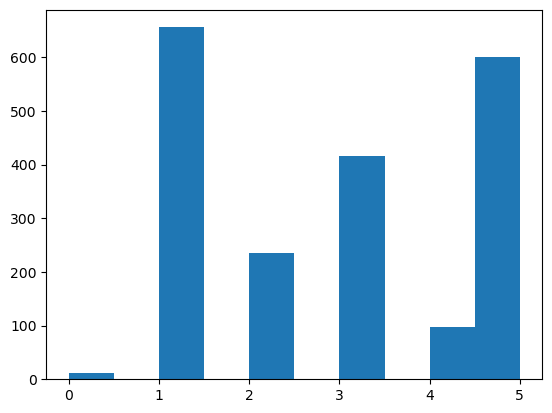

In [78]:
plt.hist(merged_df['NomiantionToInt'], bins=10)
plt.show()

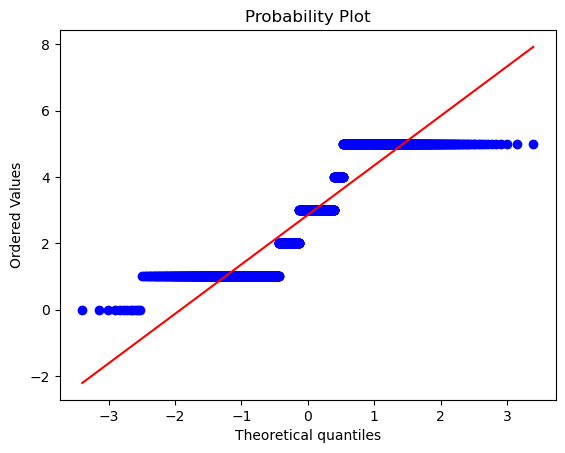

In [98]:
stats.probplot(merged_df['NomiantionToInt'], dist='norm', plot=pylab)
pylab.show()

<Axes: xlabel='NomiantionToInt'>

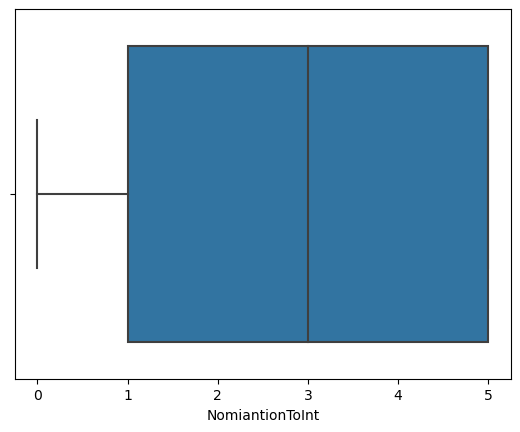

In [99]:
sns.boxplot(x=merged_df['NomiantionToInt'])

C:\Users\МОиБД\AppData\Local\Temp\ipykernel_6264\2577834100.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=merged_df['NomiantionToInt'])


<Axes: ylabel='Density'>

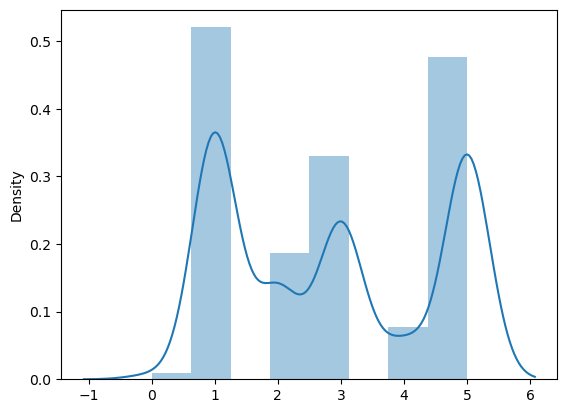

In [101]:
sns.distplot(x=merged_df['NomiantionToInt'])

#### Визуализация зависимостей признаков от целевой переменной

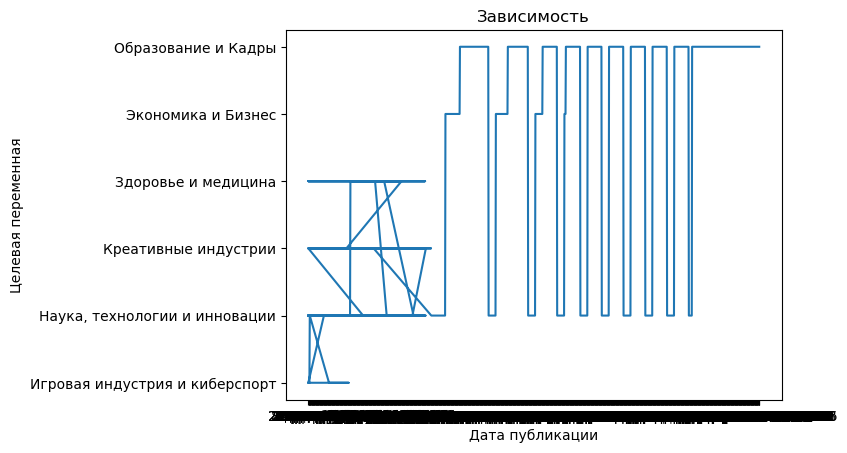

In [81]:
# визализация зависимости даты от номинации
plt.plot(merged_df['DatePublish'], merged_df['Nominations'])
plt.xlabel('Дата публикации')
plt.ylabel('Целевая переменная')
plt.title('Зависимость')
plt.show()

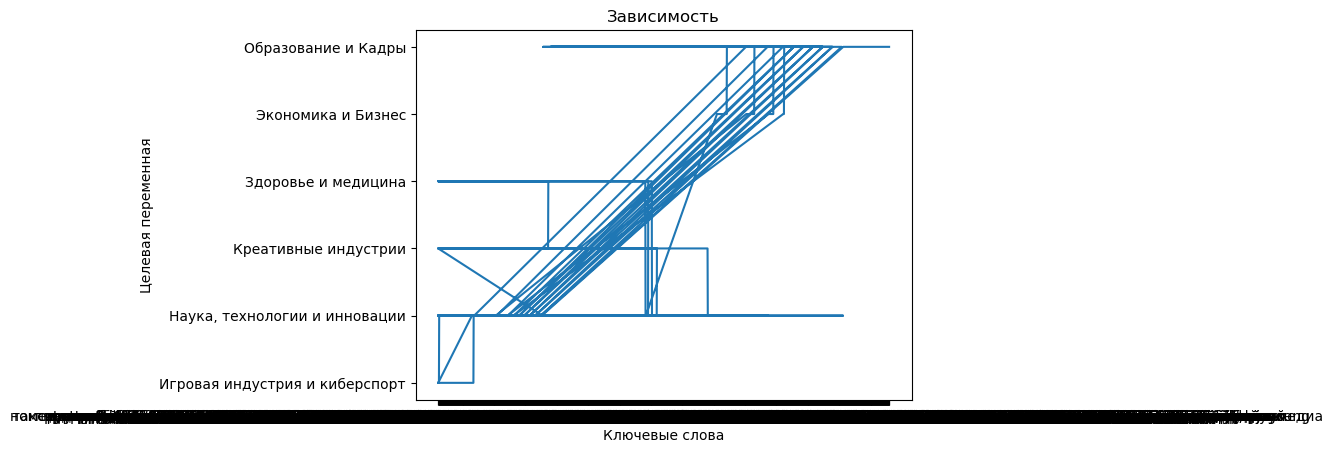

In [82]:
# визализация зависимости ключевых слов от номинации
plt.plot(merged_df['keyword'], merged_df['Nominations'])
plt.xlabel('Ключевые слова')
plt.ylabel('Целевая переменная')
plt.title('Зависимость')
plt.show()

#### Вывод об ассиметрии и мере скошенности

In [83]:
skewness = merged_df['NomiantionToInt'].skew()
kurtosis = merged_df['NomiantionToInt'].kurtosis()


print('Ассиметрия:', skewness)
print('Мера скошенности:', kurtosis)

Ассиметрия: 0.15866003033711368
Мера скошенности: -1.523855064550665


In [87]:
# сохраняем DataFrame в файл
merged_df.to_csv(r'C:\Users\МОиБД\Downloads\Report1.csv', index=False, encoding='utf-8')

### 1.6 Подготовка отчета


__1.1 Парсинг данных__ Пункт был выполнен без нареканий. Сначала был выполнен парсинг Json, затем был выполнен парсинг вордовского документа с необходимыми компаниями, после парсинга компаний были выделены компании, которых не было в json файле.
Затем был выполнен парсинг сайта Habr, по поиску из всех номинированных компаний были выделены их статьи и информация о компаниях, также стали известны компании, которых полностью нет ни на Habr, ни в Json, сами компании: Gett, MMA.Metaratings, Метарейтинг, Balance Platform, Дневник МЭШ, скорее всего, причина в том, что эти компании удалили с сайта Habr.

__1.2 Формирование структуры набора данных__ Набор данных успешно был сформирован, все переменные были полностью записаны. Целевыми переменными являются: TitleCompany, TextPostLemat, TextPostToken.

__1.3 Предварительная обработка текстовых данных__ Предварительная обработка данных выполнена без проблем, также были обработаны пропуски. Были созданы самые необходимые признаки TextPostLemat и TextPostToken, в дальнейшем будет производиться работа только с ними. Работа с обработкой данных завершена, данные полностью обработаны.

__1.4 Поиск ключевых слов/n-грамм. Векторизация текста__ Пункт был выполнен успешно, без каких либо проблем. Биграммы, триграммы и векторизация выполнены успешно. А также добавлены как новые признаки. Была выполнена векторизация через CountVectorizer.

    __1.4.1 Выбранный метод биграмм nltk.ngrams__ 
    
    __1.4.2 Выбранный метод триграмм nltk.ngrams__
    
    __1.4.3 Выбранный метод ключевых слов nltk.FreqDist__ 
    
    Каждый из трех методов выбран по причине удобного и простого использования, по сравнению с другими. Были перебраны несколько алгоритмов, некоторые либо работали некорректно, либо работали не так удобно, как nltk.ngrams и nltk.FreqDist.
    
__1.5 Разведочный анализ__ Данный пункт выполнен без каких либо проблем. В пункте был прочитан Json файл, и стали известны какие номинации у каких компаний. Поэтому все названия статей были обработаны для полного соответствия друг с другом, и затем присвоины номинации. Номинация - это целевая переменная, основная работа в дальнейшем будет проходить с ней. Также была выполнена проверка нормальности распределения целевой переменной. Проведена графическая оценка (на основе ключевых слов и даты публикации) и статическая оценка распределения целевой переменной. Сделан вывод о типе распределения, ассиметрии и мере скошенности.


### Вывод

В итоге датафрейм полностью готов к 2-ей Сессии. Номинации присвоены корректно.
